In [1]:
!unzip "/content/proyecto_IA_v2.zip" -d /content

Archive:  /content/proyecto_IA_v2.zip
   creating: /content/proyecto_IA_v2/
   creating: /content/proyecto_IA_v2/test/
   creating: /content/proyecto_IA_v2/test/images/
  inflating: /content/proyecto_IA_v2/test/images/train_19.png  
  inflating: /content/proyecto_IA_v2/test/images/train_20.png  
  inflating: /content/proyecto_IA_v2/test/images/train_21.png  
  inflating: /content/proyecto_IA_v2/test/images/train_23.png  
  inflating: /content/proyecto_IA_v2/test/images/train_26.png  
  inflating: /content/proyecto_IA_v2/test/images/train_27.png  
  inflating: /content/proyecto_IA_v2/test/images/train_29.png  
  inflating: /content/proyecto_IA_v2/test/images/train_30.png  
  inflating: /content/proyecto_IA_v2/test/images/train_31.png  
  inflating: /content/proyecto_IA_v2/test/images/train_32.png  
   creating: /content/proyecto_IA_v2/test/labels/
  inflating: /content/proyecto_IA_v2/test/labels/train_19.txt  
  inflating: /content/proyecto_IA_v2/test/labels/train_20.txt  
  inflating: 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 1. CONFIGURACIÓN INICIAL ---
PATH_BASE = '/content/proyecto_IA_v2/'
PATH_TRAIN = os.path.join(PATH_BASE, 'train')
PATH_VAL = os.path.join(PATH_BASE, 'val')

IMG_SIZE = 640      # ResNet50 funciona bien con este tamaño
BATCH_SIZE = 32     # Puedes aumentar el batch size con una GPU potente
EPOCHS = 30         # El Transfer Learning suele requerir menos épocas

NUM_CLASSES = 15

LEARNING_RATE = 0.001 # Una tasa de aprendizaje estándar para Adam

In [3]:
def load_data(data_path):
    """Lee las rutas de imágenes y sus correspondientes etiquetas."""
    image_dir = os.path.join(data_path, 'images')
    label_dir = os.path.join(data_path, 'labels')

    image_paths = []
    labels = []

    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_dir, filename)
            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_path = os.path.join(label_dir, label_filename)

            if os.path.exists(label_path):
                image_paths.append(img_path)
                with open(label_path, 'r') as f:
                    line = f.readline().strip()
                    parts = line.split()
                    class_id = int(parts[0])
                    bbox_coords = [float(p) for p in parts[1:]]
                    labels.append({'class_id': class_id, 'bbox': bbox_coords})
    return image_paths, labels

# --- 3. PROCESAMIENTO DE DATOS CON tf.data ---
def data_generator(image_paths, labels, batch_size, is_training=True):
    """Crea un pipeline de datos eficiente con tf.data."""
    bbox_list = [l['bbox'] for l in labels]
    class_id_list = [l['class_id'] for l in labels]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bbox_list, class_id_list))

    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    def preprocess_image(image_path, bbox, class_id):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

        # IMPORTANTE: Usar la función de preprocesamiento específica de ResNet
        img = tf.keras.applications.resnet.preprocess_input(img)

        return img, (tf.cast(bbox, dtype=tf.float32), tf.cast(class_id, dtype=tf.int32))

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [4]:
# --- 4. CONSTRUCCIÓN DEL MODELO CON TRANSFER LEARNING ---
def build_resnet_model(num_classes):
    """Crea un modelo de detección usando ResNet50 como backbone."""

    # --- Backbone (Extractor de Características) ---
    # 1. Cargar ResNet50 pre-entrenado en ImageNet, sin su capa final.
    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # 2. Congelar el backbone.
    # Sus pesos no se actualizarán durante el entrenamiento.
    base_model.trainable = False

    # --- Cabezales de Detección Personalizados ---
    # 3. Tomar la salida del backbone y añadir una capa de Pooling.
    inputs = base_model.input
    x = base_model.output
    # GlobalAveragePooling2D es una alternativa moderna a Flatten.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x) # Capa intermedia densa

    # 4. Crear el cabezal de regresión para la Bounding Box
    bbox_output = layers.Dense(256, activation='relu')(x)
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(bbox_output)

    # 5. Crear el cabezal de clasificación para nuestras 15 clases
    class_output = layers.Dense(512, activation='relu')(x)
    class_output = layers.Dropout(0.5)(class_output) # Regularización
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(class_output)

    # 6. Unir todo en un solo modelo
    model = keras.Model(inputs=inputs, outputs=[bbox_output, class_output])

    return model

# Construir el modelo
model = build_resnet_model(NUM_CLASSES)

# Mostrar el resumen del modelo.
# Fíjate en la enorme cantidad de parámetros "no entrenables". ¡Ese es el poder del Transfer Learning!
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 646, 646,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 320, 320,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 320, 320,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 320, 320,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 322, 322,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 160, 160,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 160, 160,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 160, 160,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 160, 160,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 160, 160,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 160, 160,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 160, 160,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 160, 160,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 160, 160,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 160, 160,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 160, 160,  │      1,024 │ conv2_block1_3_c

 Total params: 26,481,811 (101.02 MB)

 Trainable params: 2,894,099 (11.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
losses = {
    "bbox_output": tf.keras.losses.MeanSquaredError(),
    "class_output": tf.keras.losses.SparseCategoricalCrossentropy()
}

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss=losses,
              metrics={"class_output": "accuracy"})


train_images, train_labels = load_data(PATH_TRAIN)
val_images, val_labels = load_data(PATH_VAL)

train_dataset = data_generator(train_images, train_labels, BATCH_SIZE)
val_dataset = data_generator(val_images, val_labels, BATCH_SIZE, is_training=False)

print("\n--- INICIANDO ENTRENAMIENTO (TRANSFER LEARNING) ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)



--- INICIANDO ENTRENAMIENTO (TRANSFER LEARNING) ---
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - bbox_output_loss: 0.0847 - class_output_accuracy: 0.3891 - class_output_loss: 3.1720 - loss: 3.2996 - val_bbox_output_loss: 0.0295 - val_class_output_accuracy: 0.7778 - val_class_output_loss: 1.6401 - val_loss: 1.6696
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - bbox_output_loss: 0.0253 - class_output_accuracy: 0.6429 - class_output_loss: 1.8347 - loss: 1.8829 - val_bbox_output_loss: 0.0257 - val_class_output_accuracy: 0.7778 - val_class_output_loss: 1.6542 - val_loss: 1.6799
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - bbox_output_loss: 0.0234 - class_output_accuracy: 0.5438 - class_output_loss: 1.6853 - loss: 1.7121 - val_bbox_output_loss: 0.0233 - val_class_output_accuracy: 0.7778 - val_class_output_loss: 1.3134 - val_loss: 1.3367
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - bbox_output_loss: 0.0231 - class_output_accuracy: 0.5755 - class_output_loss: 1.4607 - loss: 

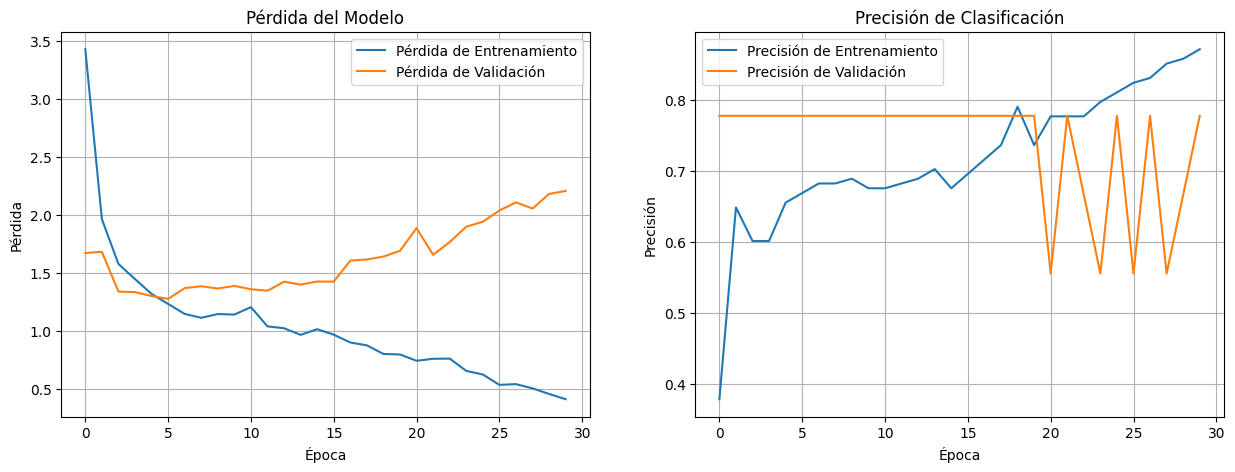

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Pérdida de Entrenamiento')
ax1.plot(history.history['val_loss'], label='Pérdida de Validación')
ax1.set_title('Pérdida del Modelo')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend(); ax1.grid(True)

ax2.plot(history.history['class_output_accuracy'], label='Precisión de Entrenamiento')
ax2.plot(history.history['val_class_output_accuracy'], label='Precisión de Validación')
ax2.set_title('Precisión de Clasificación')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend(); ax2.grid(True)
plt.show()

# --- CELDA 7: VISUALIZACIÓN DE PREDICCIONES ---
def predict_and_visualize(model, dataset, num_images=5):
    # ¡Importante! Necesitamos "des-normalizar" las imágenes para verlas correctamente
    def denormalize(image):
        # La función de preprocesamiento de ResNet resta la media de ImageNet
        # Esta es una aproximación para revertirlo a un rango visible [0, 1]
        image[..., 0] += 103.939
        image[..., 1] += 116.779
        image[..., 2] += 123.68
        image = image[..., ::-1] # BGR -> RGB
        return np.clip(image / 255., 0, 1)

    images, (true_bboxes, true_classes) = next(iter(dataset))
    pred_bboxes, pred_classes_probs = model.predict(images)

val_dataset_vis = data_generator(val_images, val_labels, BATCH_SIZE, is_training=False)
predict_and_visualize(model, val_dataset_vis)